<a href="https://colab.research.google.com/github/Haseonglee/springboot-webservice1/blob/master/model/covid-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

img_dir = '/content/drive/MyDrive/Covid Model/CT'
categories = ['COVID','Non-COVID']
n_classes = len(categories)

image_w = 112
image_h = 112


pixel = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.png")


    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            #Y는 0 아니면 1이니까 idx값으로 넣는다.
            X.append(data)
            y.append(idx)
            if i % 300 == 0:
                print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")
X = np.array(X)
y = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

xy = (X_train, X_test, y_train, y_test)
np.save("/content/drive/MyDrive/Covid Model/binary_image_data.npy", xy)

COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm_z139.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm_z003.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm_z013.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/tr_mask_z016.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/coronacases_org_008_z226.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/coronacases_org_009_z216.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/coronacases_org_010_z294.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/coronacases_org_004_z170.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/coronacases_org_005_z161.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/coronacases_org_006_z193.png
COVID  :  /content/drive/MyDrive/Covid Model/CT/COVID/Covid (835).png
COVID  :  /content/dri

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

#np_load_old = np.load
#np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
X_train, X_test, y_train, y_test = np.load('/content/drive/MyDrive/Covid Model/binary_image_data.npy', allow_pickle=True)
#np.load = np_load_old
print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(6993, 112, 112, 3)
6993
[4841 2152]
[505 272]


In [5]:
IMAGE_SIZE = 112
BATCH_SIZE = 16
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(6993, 112, 112, 3) (6993, 2) (777, 112, 112, 3) (777, 2)
(5594, 112, 112, 3) (5594, 2) (777, 112, 112, 3) (777, 2) (1399, 112, 112, 3) (1399, 2)


In [7]:
from tensorflow.keras.utils import Sequence
import cv2
import sklearn

# 입력 인자 images_array labels는 모두 numpy array로 들어옴. 
# 인자로 입력되는 images_array는 전체 32x32 image array임. 
class _Dataset(Sequence):
    def __init__(self, images_array, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        images_array: 원본 32x32 만큼의 image 배열값. 
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        # 인자로 입력되는 images_array는 전체 32x32 image array임.
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels) / self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        images_fetch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # 변환된 image 배열값을 담을 image_batch 선언. image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((images_fetch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(images_fetch.shape[0]):
            #image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            # 원본 image를 IMAGE_SIZE x IMAGE_SIZE 크기로 변환
            image = cv2.resize(images_fetch[image_index], (IMAGE_SIZE, IMAGE_SIZE))
            # 만약 augmentor가 주어졌다면 이를 적용. 
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
                
            # 만약 scaling 함수가 입력되었다면 이를 적용하여 scaling 수행. 
            if self.pre_func is not None:
                image = self.pre_func(image)
            
            # image_batch에 순차적으로 변환된 image를 담음.               
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 원본 image배열과 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)
        else:
            pass

In [8]:
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess

# tr_ds = _Dataset(X_train, y_train, batch_size=BATCH_SIZE, augmentor=None, shuffle=True, pre_func=vgg_preprocess)
val_ds = _Dataset(X_val, y_val, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=vgg_preprocess)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from PIL import Image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
import numpy as np
import pandas as pd
import os
import cv2
import re
import skimage
import matplotlib.pyplot as plt
 
input_tensor = Input(shape=(112, 112, 3))
base_model = VGG19(input_tensor=input_tensor, include_top=False, weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(layers.BatchNormalization())
model.add(layers. GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_classes, activation = 'softmax'))
model.summary()


80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 512)         2048      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________

In [10]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model_path = "COVIDMD.h5"
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
#ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, 
                                 save_best_only=True)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=100,
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(X_val.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, checkpoint]
#                     callbacks=[rlr_cb, ely_cb, checkpoint]
                   )
                   

Epoch 1/100
350/350 [==============================] - 65s 92ms/step - loss: 0.4336 - accuracy: 0.8039 - val_loss: 82.8728 - val_accuracy: 0.3174

Epoch 00001: val_loss improved from inf to 82.87278, saving model to COVIDMD.h5
Epoch 2/100
350/350 [==============================] - 31s 87ms/step - loss: 0.2599 - accuracy: 0.8906 - val_loss: 31.3046 - val_accuracy: 0.3174

Epoch 00002: val_loss improved from 82.87278 to 31.30463, saving model to COVIDMD.h5
Epoch 3/100
350/350 [==============================] - 32s 90ms/step - loss: 0.2067 - accuracy: 0.9140 - val_loss: 144.2349 - val_accuracy: 0.3174

Epoch 00003: val_loss did not improve from 31.30463
Epoch 4/100
350/350 [==============================] - 32s 91ms/step - loss: 0.1818 - accuracy: 0.9240 - val_loss: 107.6144 - val_accuracy: 0.3174

Epoch 00004: val_loss did not improve from 31.30463
Epoch 5/100
350/350 [==============================] - 32s 90ms/step - loss: 0.1583 - accuracy: 0.9385 - val_loss: 188.9611 - val_accuracy: 0

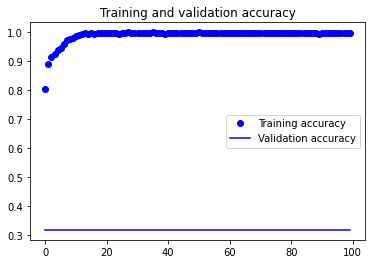

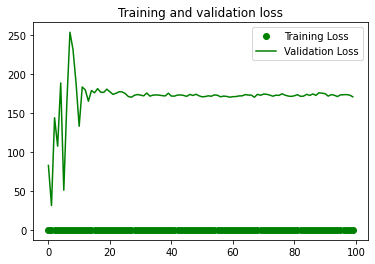

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:

print("정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 4s 70ms/step - loss: 0.0798 - accuracy: 0.9833
정확도 : 0.98 


In [22]:
import os, re, glob
import cv2
import numpy as np
import shutil
from numpy import argmax
from keras.models import load_model

image_dir = '/content/drive/MyDrive/Covid Model/test/COVID/'
categories = ['COVID','Non-COVID']

def Dataization(img_path):
    image_w = 112
    image_h = 112
    img = cv2.imread(img_path)
    img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])
    return (img/256)
 
src = []
name = []
test = []

for file in os.listdir(image_dir):
    if (file.find('.png') is not -1):      
        src.append(image_dir + file)
        name.append(file)
        test.append(Dataization(image_dir + file))
 
 
test = np.array(test)
model = load_model('/content/drive/MyDrive/Covid Model/COVIDMD (3).h5')
predict = model.predict_classes(test)
 
for i in range(len(test)):
    print(name[i] + " : , Predict : "+ str(categories[predict[i]]))


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


kjr-21-e24-p2-8.png : , Predict : COVID
kjr-21-e25-p1-6.png : , Predict : Non-COVID
kjr-21-e24-p3-16.png : , Predict : COVID
kjr-21-e24-p5-29.png : , Predict : COVID
kjr-21-e24-p5-31.png : , Predict : COVID
